# Task 4: Understand speech recognition and speech-to-text conversion

## 1. Design a simple neural network to recognize spoken digits: Free Spoken Digit Dataset contains recordings of spoken digits in wave files at 8kHz. This dataset contains 50 recordings for every 10 digits per every 6 speakers. This dataset in total contains 3000 recordings in English pronunciations. 

## 2. Design a program to convert the given dataset MP3 file into text. Show your code and results in your report. Program can be done with open-source python libraries, e.g. “speech_recognition” or “pydub”.

## 3. Establish your own input dataset, and convert your own speech data into text. For example, by recording:“ I am having fun with human robot interaction class.” Show your code and results in your report.

## 5. Write down the problems you encountered during the experiment, the solutions, and your experiences.

In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

# 定义数据目录
data_dir = 'dataset_for_task4/free-spoken-digit-dataset/recordings'

# 准备用于存储数据和标签的列表
data = []
labels = []

# 计算全局最大时间帧数
max_time_frames_global = 0

# 遍历数据目录
for filename in os.listdir(data_dir):
    if filename.endswith('.wav'):
        # 解析文件名以获取数字和说话者信息
        digit, speaker, _ = filename.split('_')
        
        # 加载音频文件
        audio_path = os.path.join(data_dir, filename)
        y, sr = librosa.load(audio_path)  # 读取整个音频文件
        
        # 将音频波形转换为频谱图
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

        # 计算当前音频文件的时间帧数
        num_time_frames = D.shape[1]
        max_time_frames_global = max(max_time_frames_global, num_time_frames)
        
        # 存储数据和标签
        data.append(D)
        labels.append(int(digit))
print('全局最大时间帧数：', max_time_frames_global)
# 将所有频谱图调整为全局最大时间帧数
for i in range(len(data)):
    num_frames = data[i].shape[1]
    if num_frames < max_time_frames_global:
        # 使用填充将时间帧数调整为全局最大值
        padding = max_time_frames_global - num_frames
        data[i] = np.pad(data[i], ((0, 0), (0, padding)), mode='constant')

# 将数据和标签转换为NumPy数组
data = np.array(data)
labels = np.array(labels)

# 划分训练集和测试集
# X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)


全局最大时间帧数： 99


In [3]:
print('数据集大小：', data.shape)
print(labels.shape)

数据集大小： (1500, 1025, 99)
(1500,)


In [4]:
import torch
import torch.nn.functional as F
import torch.utils.data as utils_data
class ConvModule(torch.nn.Module):
    def __init__(self,input_channel=1):
        super(ConvModule, self).__init__()
        
        self.conv = torch.nn.Sequential(
            # (batch_size, input_channel, H, W)->(batch_size, 32, H-2, W-2)
            torch.nn.Conv2d(in_channels=input_channel, out_channels=32, kernel_size=3, stride=1, padding=0),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(inplace=True),
            # (batch_size, 32, H-2, W-2)->(batch_size, 64, H-4, W-4)
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(inplace=True),
            # (batch_size, 64, H-4, W-4)->(batch_size, 128, H-6, W-6)
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(inplace=True)
        )
        #(128)->(4)
        self.fc = torch.nn.Linear(128, 10)

    def forward(self, X):
        # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        X=X.unsqueeze(1)
        # X = X.to(device)
        out = self.conv(X)  # (batch_size, 128, H - 6, W - 6)
        # 48-2-2-2=42
        out = F.adaptive_avg_pool2d(out, (1,1))
        # out = F.avg_pool2d(out, 42)  # (batch_size, 128, 1, 1)
        # (batch_size, 128, 1, 1)->(batch_size, 128)
        out = out.squeeze()
        out = self.fc(out)
        return out

In [5]:
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvModule()
model.to(device)
if torch.cuda.is_available():
    model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
loss_func = nn.CrossEntropyLoss()

In [6]:
dataset_size, H, W = data.shape
print(data.shape)
print(dataset_size, H, W)

(1500, 1025, 99)
1500 1025 99


In [7]:
dataset = utils_data.TensorDataset(torch.Tensor(data), torch.LongTensor(labels))
split_ratio = 0.8
train_size = int(split_ratio * dataset_size)
test_size = dataset_size - train_size
train_set, test_set = utils_data.random_split(dataset, [train_size, test_size])
train_loader = utils_data.DataLoader(dataset=train_set, batch_size=8, shuffle=True)
test_loader = utils_data.DataLoader(dataset=test_set, batch_size=8, shuffle=True)
print('Data is ready!')

Data is ready!


epoch=0	train loss=2.293100	train accuracy=0.126	test accuracy=0.193
epoch=1	train loss=2.267142	train accuracy=0.138	test accuracy=0.157
epoch=2	train loss=2.246477	train accuracy=0.177	test accuracy=0.160
epoch=3	train loss=2.230677	train accuracy=0.175	test accuracy=0.220
epoch=4	train loss=2.203720	train accuracy=0.187	test accuracy=0.170
epoch=5	train loss=2.181560	train accuracy=0.196	test accuracy=0.207
epoch=6	train loss=2.159928	train accuracy=0.234	test accuracy=0.173
epoch=7	train loss=2.135494	train accuracy=0.224	test accuracy=0.250
epoch=8	train loss=2.119037	train accuracy=0.237	test accuracy=0.243
epoch=9	train loss=2.104626	train accuracy=0.234	test accuracy=0.283
epoch=10	train loss=2.075139	train accuracy=0.242	test accuracy=0.117
epoch=11	train loss=2.064622	train accuracy=0.263	test accuracy=0.163
epoch=12	train loss=2.048996	train accuracy=0.264	test accuracy=0.227
epoch=13	train loss=2.027550	train accuracy=0.272	test accuracy=0.313
epoch=14	train loss=2.020162	t

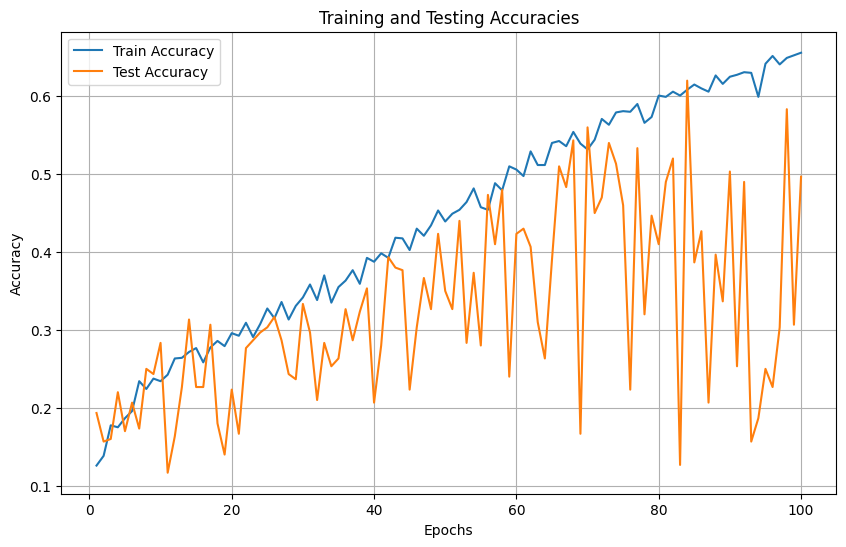

In [8]:
import matplotlib.pyplot as plt

# Lists to store training and testing accuracies for each epoch
train_accs = []
test_accs = []

best_accuracy = 0
for epoch in range(100):
    running_loss = 0.0
    train_acc = 0.0
    for step, (batch_image, batch_label) in enumerate(train_loader):
        model.train()
        model = model.to(device)
        batch_image, batch_label = batch_image.to(device), batch_label.to(device)
        batch_output = model(batch_image)
        batch_loss = loss_func(batch_output, batch_label)

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        running_loss += batch_loss.item()

        _, train_predicted = torch.max(batch_output.data, 1)
        train_acc += (train_predicted == batch_label).sum().item()

    train_acc /= train_size
    running_loss /= (step + 1)

    model.eval()
    test_acc = 0.0
    for test_image, test_label in test_loader:
        test_image, test_label = test_image.to(device), test_label.to(device)
        test_output = model(test_image)
        _, predicted = torch.max(test_output.data, 1)
        test_acc += (predicted == test_label).sum().item()
    test_acc /= test_size

    print('epoch={:d}\ttrain loss={:.6f}\ttrain accuracy={:.3f}\ttest accuracy={:.3f}'.format(
        epoch, running_loss, train_acc, test_acc))

    # Append accuracies to the lists
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    if test_acc >= best_accuracy:
        save_path = './task4_trained_models/'
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        torch.save(model.state_dict(), './task4_trained_models/FCNN_model.pkl')
        best_accuracy = test_acc

# Plot the training and testing accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy')
plt.plot(range(1, len(test_accs) + 1), test_accs, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracies')
plt.grid(True)
plt.show()
